# Step 1 : importing Essential Libraries

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.optimizers import Adam , RMSprop ,SGD ,Adadelta , Adagrad , Adamax  , Nadam

from matplotlib import pyplot
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [35]:
base_skin_dir = os.path.join('..', 'input')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

In [36]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']


In [37]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(32, 32, 3))
x_test = x_test.reshape(x_test.shape[0], *(32, 32, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(32, 32, 3))


In [38]:
input_shape = (32, 32, 3)
num_classes = 7

In [39]:
def fit_model(x_train, y_train, x_test , y_test , lrate):
  model = Sequential()
  model.add(Conv2D(64,kernel_size=(3, 3) , activation='relu',padding = 'Same',input_shape=input_shape))
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.40))

  model.add(Flatten())
  model.add(Dense(7, activation='softmax'))

  opt = SGD(lr=lrate)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  history = model.fit(x_train,y_train, validation_data=(x_test, y_test), epochs=100, verbose=0)
  
  plt.plot(history.history['acc'], label='train')
  plt.plot(history.history['val_acc'], label='test')
  plt.title('lrate='+str(lrate), fontsize=20)
  plt.ylim(0.5, 1)
  plt.xticks(fontsize=20, rotation=45)
  plt.yticks(fontsize=10, rotation=45)
  plt.legend(fontsize=20,loc='lower right')

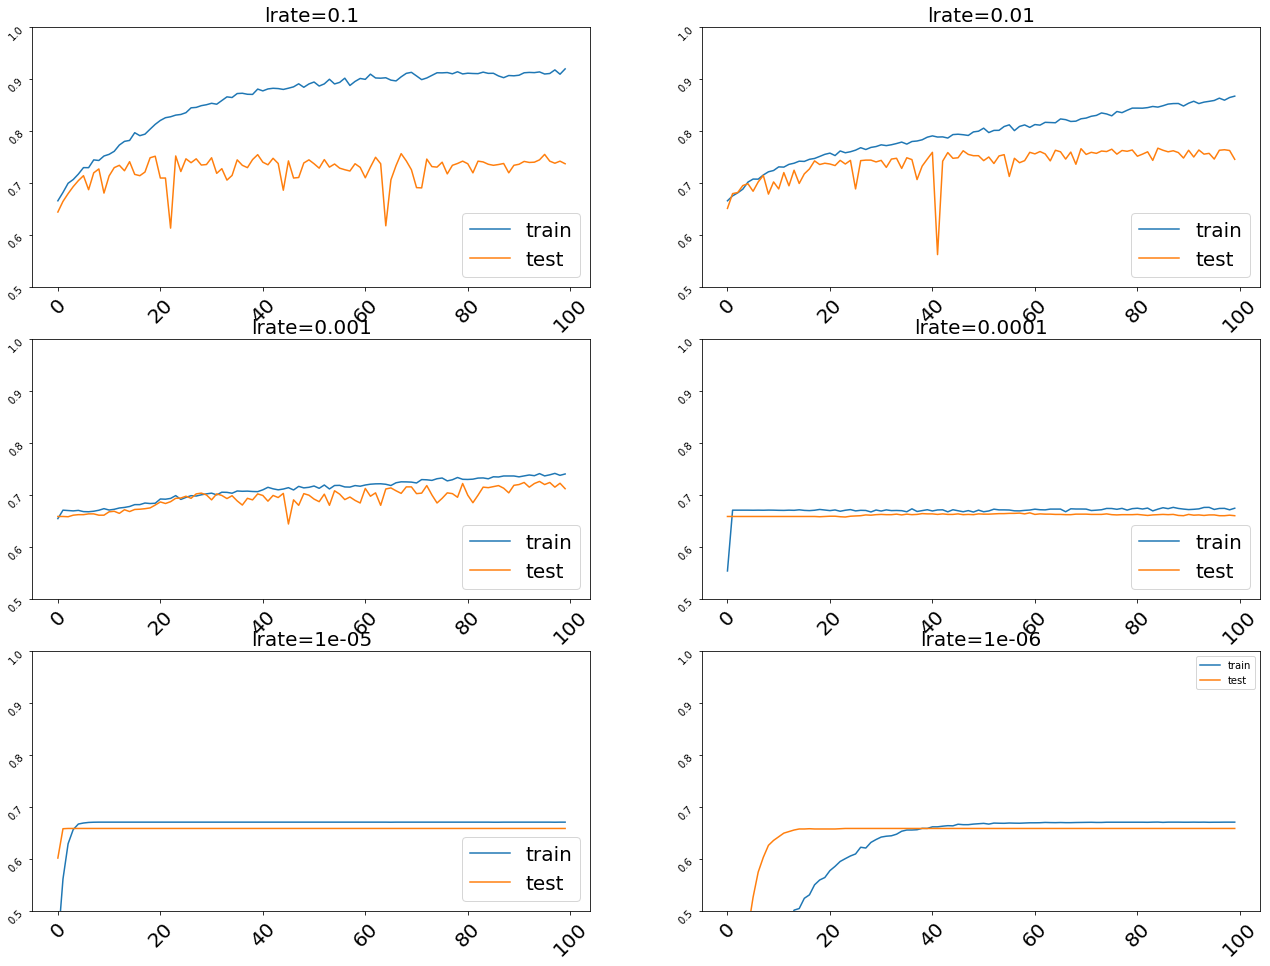

In [40]:
from IPython.display import Javascript
plt.rcParams["figure.figsize"] = (22,22)
learning_rates = [ 1E-1, 1E-2, 1E-3, 1E-4,1E-5, 1E-6]
for i in range(len(learning_rates)):
 plot_no = 420 + (i+1)
 pyplot.subplot(plot_no)
 fit_model(x_train, y_train, x_test , y_test, learning_rates[i])

 
plt.legend()
pyplot.show()

In [41]:
def fit_model(x_train, y_train, x_test , y_test , momentum):
  model = Sequential()
  model.add(Conv2D(64,kernel_size=(3, 3) , activation='relu',padding = 'Same',input_shape=input_shape))
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.40))

  model.add(Flatten())
  model.add(Dense(7, activation='softmax'))

  opt = SGD(lr=0.1, momentum=momentum)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  history = model.fit(x_train,y_train, validation_data=(x_test, y_test), epochs=100, verbose=0)
  
  plt.plot(history.history['acc'], label='train')
  plt.plot(history.history['val_acc'], label='test')
  plt.title('momentum='+str(momentum), fontsize=20)
  plt.ylim(0.5, 1)
  plt.xticks(fontsize=20, rotation=45)
  plt.yticks(fontsize=10, rotation=45)
  plt.legend(fontsize=20,loc='lower right')

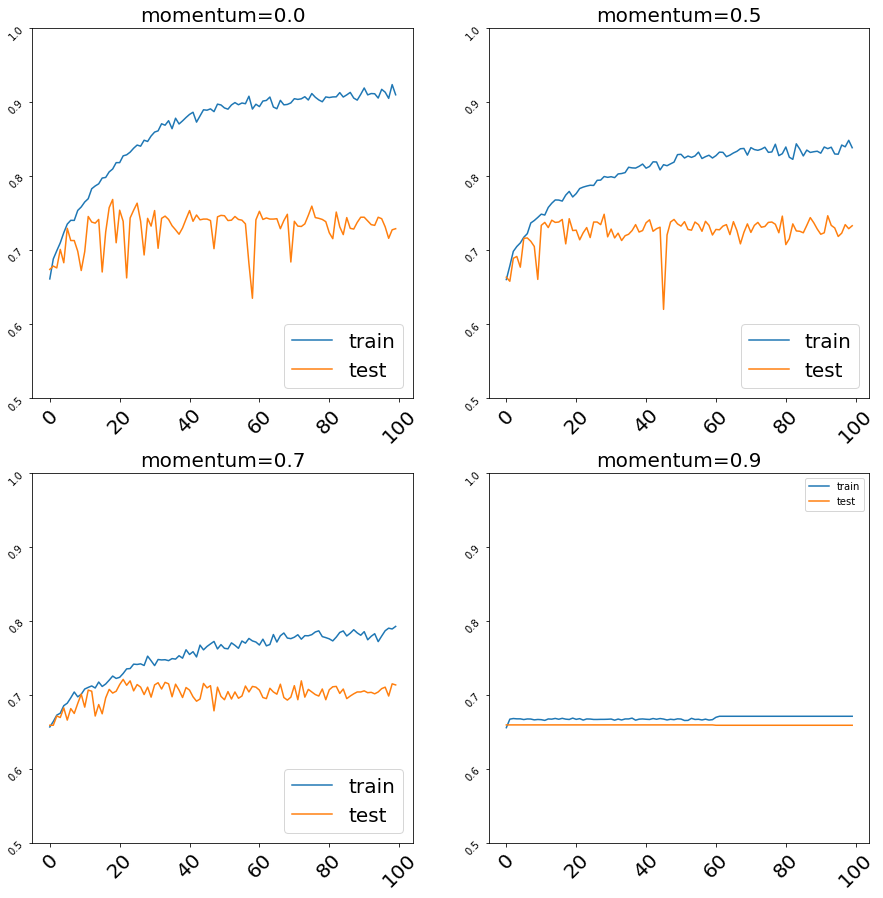

In [42]:
from IPython.display import Javascript
plt.rcParams["figure.figsize"] = (15,15)
momentums = [0.0, 0.5,0.7, 0.9,]
for i in range(len(momentums)):
 plot_no = 220 + (i+1)
 pyplot.subplot(plot_no)
 fit_model(x_train, y_train, x_test , y_test, momentums[i])

 
plt.legend()
pyplot.show()

In [43]:
def fit_model(x_train, y_train, x_test , y_test , decay):
  model = Sequential()
  model.add(Conv2D(64,kernel_size=(3, 3) , activation='relu',padding = 'Same',input_shape=input_shape))
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.40))

  model.add(Flatten())
  model.add(Dense(7, activation='softmax'))

  opt = SGD(lr=0.01,decay=decay)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  history = model.fit(x_train,y_train, validation_data=(x_test, y_test), epochs=100, verbose=0)
  
  plt.plot(history.history['acc'], label='train')
  plt.plot(history.history['val_acc'], label='test')
  plt.title('decay='+str(decay), fontsize=20)
  plt.ylim(0.5, 1)
  plt.xticks(fontsize=20, rotation=45)
  plt.yticks(fontsize=10, rotation=45)
  plt.legend(fontsize=20,loc='lower right')

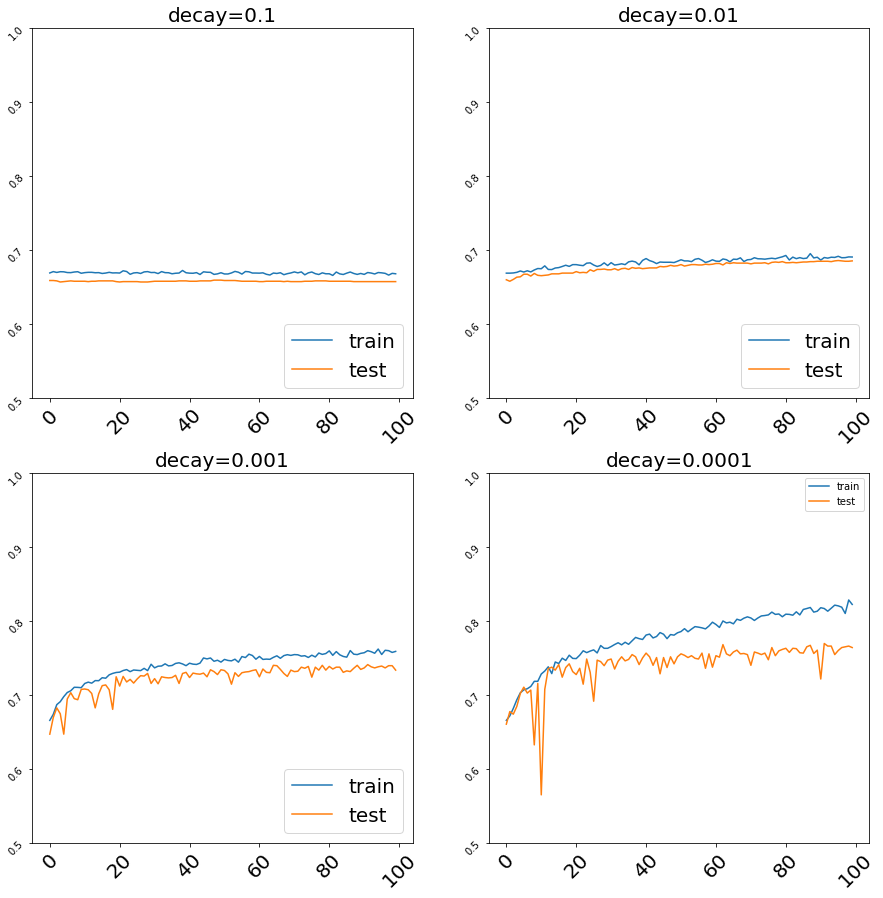

In [44]:
from IPython.display import Javascript
plt.rcParams["figure.figsize"] = (15,15)
decay = [1E-1, 1E-2, 1E-3, 1E-4]
for i in range(len(decay)):
 plot_no = 220 + (i+1)
 pyplot.subplot(plot_no)
 fit_model(x_train, y_train, x_test , y_test, decay[i])

 
plt.legend()
pyplot.show()

In [48]:
def fit_model(x_train, y_train, x_test , y_test , optimizer):
  model = Sequential()
  model.add(Conv2D(64,kernel_size=(3, 3) , activation='relu',padding = 'Same',input_shape=input_shape))
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.40))

  model.add(Flatten())
  model.add(Dense(7, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  history = model.fit(x_train,y_train, validation_data=(x_test, y_test), epochs=100, verbose=0)
  
  plt.plot(history.history['acc'], label='train')
  plt.plot(history.history['loss'], label='loss')
  pyplot.title('optimizer='+optimizer, pad=-80)
  plt.xticks(fontsize=20, rotation=45)
  plt.yticks(fontsize=10, rotation=45)
  plt.legend(fontsize=20,loc='lower right')

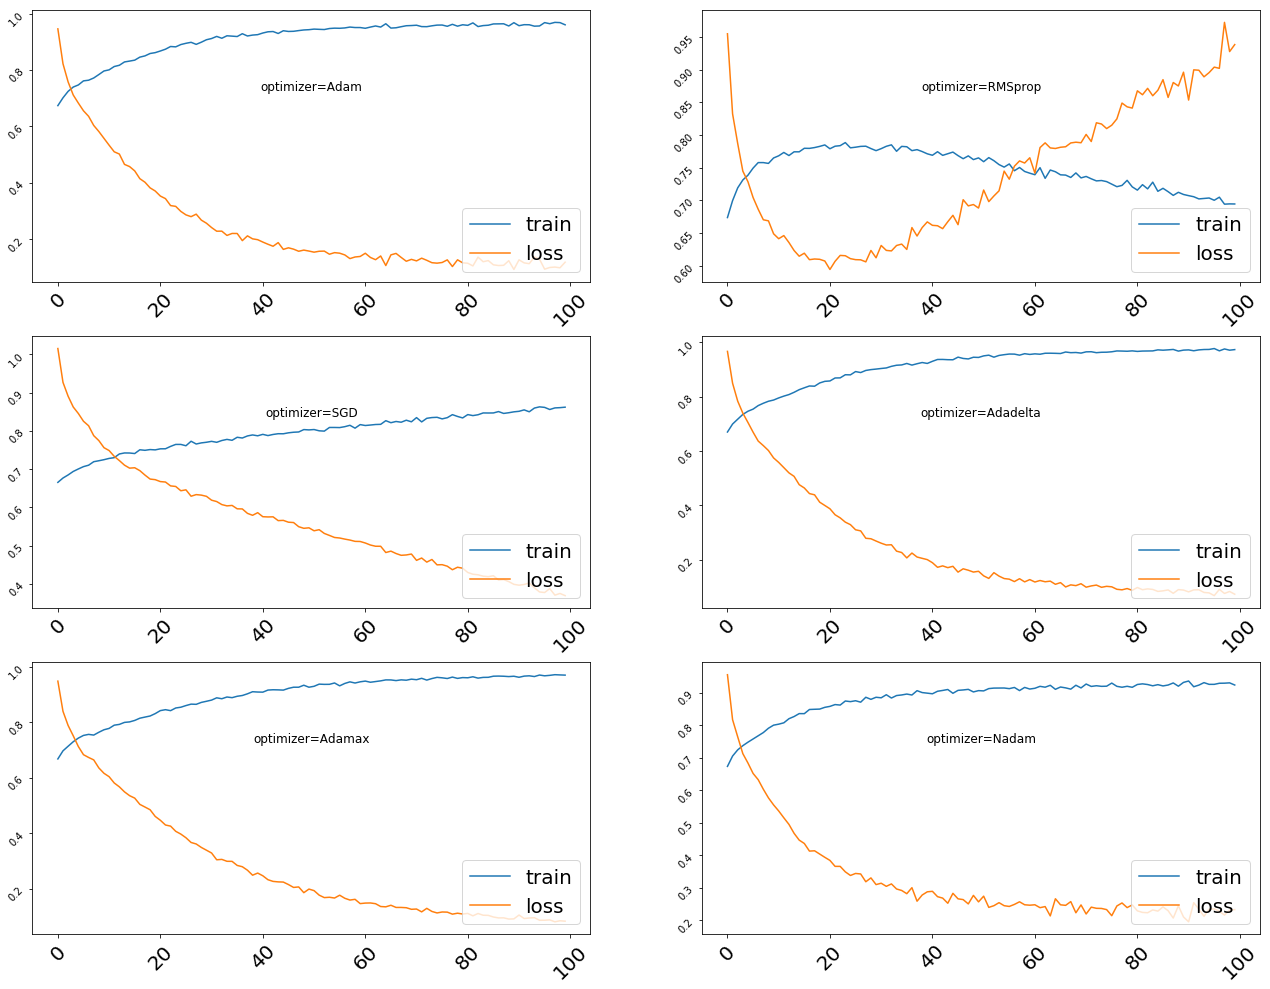

In [49]:
from IPython.display import Javascript
plt.rcParams["figure.figsize"] = (22,35)
momentums  = ["Adam","RMSprop","SGD","Adadelta","Adamax","Nadam"]
for i in range(len(momentums)):
 plot_no = 620 + (i+1)
 plt.subplot(plot_no)
 fit_model(x_train, y_train, x_test , y_test, momentums[i])

 
plt.show()